# [Контест](https://www.kaggle.com/competitions/games-rating/data) на Kaggle

Датасет хранит данные о настольных играх с веб-сайта BoardGameGeek (BGG) в феврале 2021 года. BGG — это крупнейшая онлайн-коллекция данных о настольных играх, которая состоит из данных о более чем 100 000 игр (с рейтингом и без рейтинга).

В данном соревновании необходимо реализовать линейную регрессию, которая сможет предсказывать средний рейтинг игры (`Rating Average`).

In [1017]:
%pip install opendatasets
import opendatasets as od

In [1018]:
od.download_kaggle_dataset("https://www.kaggle.com/competitions/games-rating/data", "")

Skipping, found downloaded files in "games-rating" (use force=True to force download)


## Данные: анализ и обработка

In [1019]:
import pandas as pd

In [1058]:
df = pd.read_csv("games-rating/train_data.csv")
df = pd.read_csv("games-rating/test_data.csv")

In [1059]:
print(len(df))
df

5086


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
1,12333.0,Twilight Struggle,2005.0,2,2,180,13,40814,10,"3,59",56219.0,"Action/Event, Advantage Token, Area Majority /...","Strategy Games, Wargames"
2,115746.0,War of the Ring: Second Edition,2012.0,2,4,180,13,13725,12,"4,14",22281.0,"Area Majority / Influence, Area Movement, Camp...","Thematic Games, Wargames"
3,169786.0,Scythe,2016.0,1,5,115,14,57871,14,"3,41",75640.0,"Area Majority / Influence, Card Play Conflict ...",Strategy Games
4,28720.0,Brass: Lancashire,2007.0,2,4,120,14,19400,19,"3,86",25429.0,"Hand Management, Income, Loans, Network and Ro...",Strategy Games
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,6932.0,Hi Ho! Cherry-O,1960.0,2,4,10,3,1035,20325,"1,03",1691.0,"Cooperative Game, Roll / Spin and Move",Children's Games
5082,3510.0,Battle of the Sexes,1997.0,2,8,45,12,1090,20328,"1,08",1987.0,Team-Based Game,Party Games
5083,5895.0,Hungry Hungry Hippos,1978.0,2,4,10,4,2361,20330,"1,05",2568.0,NaN,Children's Games
5084,2679.0,Mouse Trap,1963.0,2,4,30,6,2693,20333,"1,11",3408.0,Roll / Spin and Move,Children's Games


In [1060]:
df.dtypes

,0
ID,float64
Name,object
Year Published,float64
Min Players,int64
Max Players,int64
Play Time,int64
Min Age,int64
Users Rated,int64
BGG Rank,int64
Complexity Average,object


По какой-то причине, значения `Rating Average` и `Complexity Average` представлены в виде чисел с плавающей точкой, однако разделитель в них - запятая (из-за чего `pandas` не воспринимает их как `float64`).

Поправим это:

In [1061]:
#df["Rating Average"] = df["Rating Average"].astype(str).str.replace(",", ".").astype("float64")
df["Complexity Average"] = df["Complexity Average"].astype(str).str.replace(",", ".").astype("float64")

df.dtypes


,0
ID,float64
Name,object
Year Published,float64
Min Players,int64
Max Players,int64
Play Time,int64
Min Age,int64
Users Rated,int64
BGG Rank,int64
Complexity Average,float64


Характеристики игры:
* `ID` - Идентификатор настольной игры
* `Name` - Имя
* `Year Published` - Год публикации
* `Min Players` - Рекомендуемое минимальное количество игроков
* `Max Players` - Рекомендуемое максимальное количество игроков
* `Play Time` - Время игры
* `Min Age` - Рекомендуемый минимальный возраст игроков
* `Users Rated` - Количество пользователей, оценивших игру
* `Rating Average` - Средний рейтинг, полученный игрой (целевая переменная)
* `BGG Rank` - Рейтинг от BGG
* `Complexity Average` - Среднее значение сложности игры
* `Owned Users` - Количество зарегистрированных BGG владельцев игры
* `Mechanics` - Механика, используемая в игре
* `Domains` - Домены настольных игр, которым принадлежит игра

In [1062]:
df.isna().sum()

,0
ID,6
Name,0
Year Published,0
Min Players,0
Max Players,0
Play Time,0
Min Age,0
Users Rated,0
BGG Rank,0
Complexity Average,0


In [1025]:
#df = df.dropna()  # Привет из будущего: после удаления пропусков, удается пробить барьер в 0.36 MSE (хотя мне удавалось дойти до 0.3 и так)
                  # На самом деле в этом есть логика - игры, мало кому интересные, скорее всего почти не будут оценены

Пустых данных в основных численных колонках почти нет, поэтому очистка датасета не требуется. Что делать с `Mechanics` и `Domains` будет указано потом.

Очевидно, что идентификатор игры в базе данных и её название никак не влияют на целевую переменную - **удалим `ID` и `Name`** из датасета

In [1063]:
df = df.drop(["ID", "Name"], axis=1)

`Mechanics` и `Domains` - важные характеристики, однако они не являются числовыми.

Проанализируем их:

In [1064]:
CATEGORIAL_FEATURES = ["Mechanics", "Domains"]

In [1028]:
different_mechanics = set()
for mechanics in df["Mechanics"]:
    if not pd.isna(mechanics):
      mechanics = map(str.strip, mechanics.split(", "))
      different_mechanics.update(mechanics)

print(len(different_mechanics))
print(different_mechanics)

182
{'Cooperative Game', 'Action Timer', 'Line of Sight', 'Tech Trees / Tech Tracks', 'Drafting', 'Lose a Turn', 'Re-rolling and Locking', 'Map Addition', 'Secret Unit Deployment', 'Variable Set-up', 'Area Majority / Influence', 'Turn Order: Random', 'Deck Construction', 'Dice Rolling', 'Hidden Roles', 'Victory Points as a Resource', 'Connections', 'Random Production', 'Track Movement', 'Traitor Game', 'End Game Bonuses', 'Kill Steal', 'Auction: Once Around', 'Worker Placement', 'Action/Event', 'Finale Ending', 'Turn Order: Pass Order', 'Turn Order: Progressive', 'Events', 'Auction: Turn Order Until Pass', 'Resource to Move', 'Card Play Conflict Resolution', 'Rondel', 'Crayon Rail System', 'Paper-and-Pencil', 'Layering', 'Investment', 'Stacking and Balancing', 'Bingo', 'Delayed Purchase', 'Action Retrieval', 'Team-Based Game', 'Ratio / Combat Results Table', 'Set Collection', 'Square Grid', 'Bribery', 'Follow', 'Impulse Movement', 'Turn Order: Auction', 'Three Dimensional Movement', 'A

In [1029]:
different_domains = set()
for domains in df["Domains"]:
    if not pd.isna(domains):
      domains = map(str.strip, domains.split(", "))
      different_domains.update(domains)

print(len(different_domains))
print(different_domains)

8
{'Customizable Games', 'Strategy Games', 'Party Games', 'Thematic Games', 'Abstract Games', 'Family Games', "Children's Games", 'Wargames'}


**One-hot кодирование** - наш выбор. Оно позволит перевести все категориальные данные в численный вид, а также выразить столбики `Mechanics` и `Domains` как сумму векторов, представляющих отдельные элементы.

In [1030]:
import numpy as np

In [1031]:
def encode(size: int, index: int) -> np.ndarray:
    result = np.zeros(size)
    result[index] = 1
    return result

mechanics_encoding = {mechanic: encode(len(different_mechanics), i) for i, mechanic in enumerate(different_mechanics)}
mechanics_encoding[pd.NA] = np.zeros(len(different_mechanics))

domains_encoding = {domain: encode(len(different_domains), i) for i, domain in enumerate(different_domains)}
domains_encoding[pd.NA] = np.zeros(len(different_domains))

In [1032]:
from functools import reduce
from operator import add

def encode_cell(encoding: dict):

    def encoding_function(items):
        if pd.isna(items):
            return encoding[pd.NA]
        return reduce(add, map(lambda item: encoding[item.strip()], items.split(", ")))

    return encoding_function

In [1065]:
encoded_mechanics = df["Mechanics"].apply(encode_cell(mechanics_encoding))
encoded_domains = df["Domains"].apply(encode_cell(domains_encoding))

train_df = pd.concat([df.drop(CATEGORIAL_FEATURES, axis=1), encoded_mechanics, encoded_domains], axis=1)
train_df

,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,2015.0,2,4,60,13,41643,2,2.84,65294.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1,2005.0,2,2,180,13,40814,10,3.59,56219.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2,2012.0,2,4,180,13,13725,12,4.14,22281.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]"
3,2016.0,1,5,115,14,57871,14,3.41,75640.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,2007.0,2,4,120,14,19400,19,3.86,25429.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...
5081,1960.0,2,4,10,3,1035,20325,1.03,1691.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
5082,1997.0,2,8,45,12,1090,20328,1.08,1987.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5083,1978.0,2,4,10,4,2361,20330,1.05,2568.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
5084,1963.0,2,4,30,6,2693,20333,1.11,3408.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


Посмотрим на корреляцию признаков (вычислить ее с учетом того, что часть признаков мы закодировали - нельзя, поэтому будем визуализировать без них):

In [1034]:
correlation_matrix = train_df.drop(CATEGORIAL_FEATURES, axis=1).corr()
correlation_matrix

,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
Year Published,1.000000,-0.016228,-0.007565,0.007232,0.091842,0.012105,0.079546,-0.085764,0.036625,0.018334
Min Players,-0.016228,1.000000,0.108232,0.028361,0.042317,-0.016869,-0.158291,0.096783,-0.175218,-0.028768
Max Players,-0.007565,0.108232,1.000000,-0.007540,0.017650,0.002174,-0.043786,0.028195,-0.105990,0.003990
Play Time,0.007232,0.028361,-0.007540,1.000000,0.038525,-0.003893,0.080006,-0.041497,0.168908,-0.002098
Min Age,0.091842,0.042317,0.017650,0.038525,1.000000,0.075521,0.187403,-0.210580,0.281572,0.086086
Users Rated,0.012105,-0.016869,0.002174,-0.003893,0.075521,1.000000,0.175867,-0.321523,0.094232,0.984080
Rating Average,0.079546,-0.158291,-0.043786,0.080006,0.187403,0.175867,1.000000,-0.737897,0.470200,0.184917
BGG Rank,-0.085764,0.096783,0.028195,-0.041497,-0.210580,-0.321523,-0.737897,1.000000,-0.378614,-0.342471
Complexity Average,0.036625,-0.175218,-0.105990,0.168908,0.281572,0.094232,0.470200,-0.378614,1.000000,0.096454
Owned Users,0.018334,-0.028768,0.003990,-0.002098,0.086086,0.984080,0.184917,-0.342471,0.096454,1.000000


In [1035]:
import matplotlib.pyplot as plt
import seaborn as sns

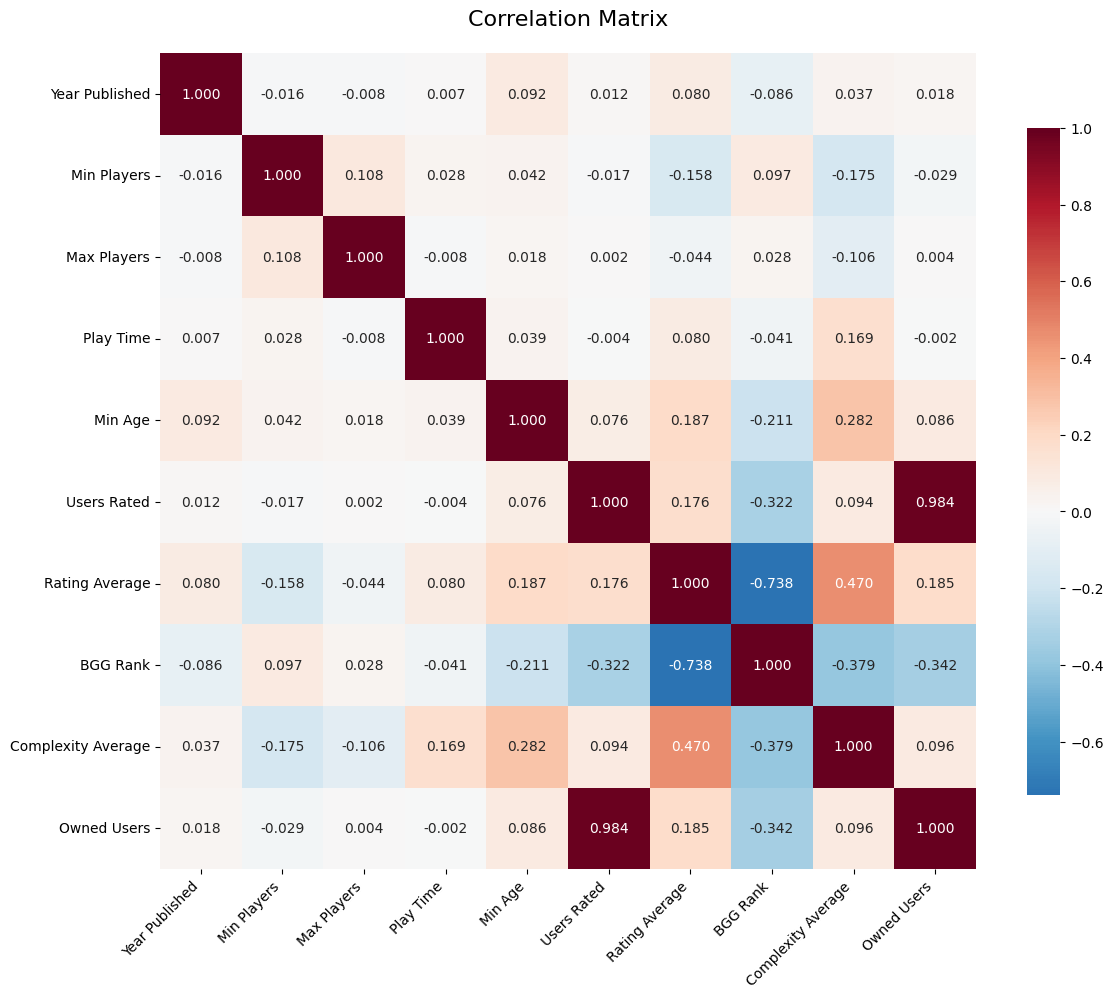

In [1036]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="RdBu_r",
            center=0,
            fmt=".3f",
            square=True,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 10})

plt.title("Correlation Matrix", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Качество линейной регрессии становится хуже, если ей приходится тренироваться на данных, зависящих друг от друга линейно. По этой причине одна из колонок `Users Rated`/`Owned Users` будет удалена. Колонки `Complexity Average` и `BGG Rank` неплохо коррелируют с целевой переменной, что в случае предсказания `Rating Average` должно наоборот, помочь.

In [1066]:
train_df = train_df.drop(["Owned Users"], axis=1)

In [1067]:
train_df.isna().sum()

,0
Year Published,0
Min Players,0
Max Players,0
Play Time,0
Min Age,0
Users Rated,0
BGG Rank,0
Complexity Average,0
Mechanics,0
Domains,0


Остался один объект с неразмеченным `Year Published`.

Заменим ему год на медиану всей колонки:

In [1068]:
train_df["Year Published"] = train_df["Year Published"].fillna(train_df["Year Published"].median())

### Немного фич-инжиниринга

In [1069]:
train_df["player_range"] = train_df["Max Players"] - train_df["Min Players"]
train_df["player_flexibility"] = train_df["player_range"] / (train_df["Min Players"] + 0.0001)
train_df["supports_solo"] = (train_df["Min Players"] == 1).astype(int)
train_df["supports_large_groups"] = (train_df["Max Players"] >= 6).astype(int)

train_df["adult_game"] = (train_df["Min Age"] >= 16).astype(int)
train_df["family_game"] = (train_df["Min Age"] <= 12).astype(int)
train_df["complexity_per_hour"] = train_df["Complexity Average"] / ((train_df["Play Time"] + 0.0001) / 60)

train_df["complexity_squared"] = train_df["Complexity Average"] ** 2
train_df["play_time_log"] = np.log1p(train_df["Play Time"])

train_df["is_modern"] = (train_df["Year Published"] > 2010).astype(int)

train_df["popularity_density"] = train_df["Users Rated"] / (2024 - train_df["Year Published"] + 1)

## Линейная регрессия

### Препроцессинг данных

In [1070]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [1042]:
X = train_df.drop(["Rating Average"], axis=1)
y = train_df["Rating Average"]

In [1043]:
print(len(X))

15257


In [1044]:
NON_CATEGORIAL_FEATURES = list(X.drop(CATEGORIAL_FEATURES, axis=1).columns)

In [1045]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=0
)

In [1046]:
scaler = StandardScaler()
X[NON_CATEGORIAL_FEATURES] = scaler.fit_transform(X[NON_CATEGORIAL_FEATURES])
X_test[NON_CATEGORIAL_FEATURES] = scaler.transform(X_test[NON_CATEGORIAL_FEATURES])

Для работы с one-hot кодированием `sklearn` не приспособлен; будем использовать `pytorch` (тем более реализация линейной регрессии на нем очевидна - это лишь один линейный слой)

In [1047]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [1048]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [1049]:
class BoardGameDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        row = self.X_data.iloc[idx]

        numeric_features = torch.FloatTensor([row[feature] for feature in NON_CATEGORIAL_FEATURES])
        categorial_features = [torch.FloatTensor(row[feature]).flatten() for feature in CATEGORIAL_FEATURES]

        features = torch.cat([numeric_features] + categorial_features)
        target = torch.FloatTensor([self.y_data.iloc[idx]])

        return features, target


train_dataset = BoardGameDataset(X, y)  # Полная тренировка
test_dataset = BoardGameDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

### Модель и тренировка

In [1050]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(len(train_dataset[0][0]), 1)

    def forward(self, x):
        return self.linear(x)


model = LinearRegression()
model.to(device)

LinearRegression(
  (linear): Linear(in_features=209, out_features=1, bias=True)
)

In [1054]:
epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

def regularized_loss(outputs, targets, model, lambda_l1=1e-5):
    mse_loss = criterion(outputs, targets)
    l1_penalty = sum(torch.norm(param, 1) for param in model.parameters())
    return mse_loss + lambda_l1 * l1_penalty

In [1055]:
from tqdm import tqdm

In [1056]:
for epoch in tqdm(range(1, epochs + 1), desc="Training"):
    model.train()

    train_loss = 0.0
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()

        predicted = model(features)

        loss = regularized_loss(predicted, target, model)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()

    if epoch % 10 == 0:
        model.eval()
        test_loss = 0.0
        #with torch.no_grad():
            #for features, target in test_loader:
            #    features, target = features.to(device), target.to(device)
            #
            #    predicted = model(features)
            #    loss = criterion(predicted, target)
            #    test_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        current_lr = scheduler.get_last_lr()[0]
        print(f"\nEpoch {epoch:4d} | LR: {current_lr:.6f} | Train MSE: {avg_train_loss:.4f} | Test MSE: {avg_test_loss:.4f}")

Training:  10%|█         | 10/100 [00:43<06:26,  4.30s/it]


Epoch   10 | LR: 0.008171 | Train MSE: 0.3011 | Test MSE: 0.0000


Training:  20%|██        | 20/100 [01:26<05:52,  4.40s/it]


Epoch   20 | LR: 0.006676 | Train MSE: 0.2865 | Test MSE: 0.0000


Training:  30%|███       | 30/100 [02:10<04:58,  4.27s/it]


Epoch   30 | LR: 0.005455 | Train MSE: 0.2837 | Test MSE: 0.0000


Training:  40%|████      | 40/100 [02:54<04:19,  4.33s/it]


Epoch   40 | LR: 0.004457 | Train MSE: 0.2819 | Test MSE: 0.0000


Training:  50%|█████     | 50/100 [03:37<03:30,  4.21s/it]


Epoch   50 | LR: 0.003642 | Train MSE: 0.2781 | Test MSE: 0.0000


Training:  60%|██████    | 60/100 [04:20<02:52,  4.31s/it]


Epoch   60 | LR: 0.002976 | Train MSE: 0.2779 | Test MSE: 0.0000


Training:  70%|███████   | 70/100 [05:03<02:10,  4.34s/it]


Epoch   70 | LR: 0.002431 | Train MSE: 0.2757 | Test MSE: 0.0000


Training:  80%|████████  | 80/100 [05:47<01:26,  4.31s/it]


Epoch   80 | LR: 0.001986 | Train MSE: 0.2738 | Test MSE: 0.0000


Training:  90%|█████████ | 90/100 [06:30<00:43,  4.37s/it]


Epoch   90 | LR: 0.001623 | Train MSE: 0.2722 | Test MSE: 0.0000


Training: 100%|██████████| 100/100 [07:12<00:00,  4.33s/it]


Epoch  100 | LR: 0.001326 | Train MSE: 0.2717 | Test MSE: 0.0000


## Подведение итогов

In [1003]:
def save(model, scaler, filepath="model.pth"):
    torch.save({
        "model_state_dict": model.state_dict(),
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "input_size": model.linear.in_features
    }, filepath)

def load(filepath="model.pth"):
    checkpoint = torch.load(filepath, weights_only=False, map_location=device)

    scaler = StandardScaler()
    scaler.mean_ = checkpoint["scaler_mean"]
    scaler.scale_ = checkpoint["scaler_scale"]

    model = LinearRegression()
    model.linear = torch.nn.Linear(checkpoint["input_size"], 1)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    return model, scaler

In [1057]:
save(model, scaler, "model.pth")

In [1071]:
X = train_df
NON_CATEGORIAL_FEATURES = list(X.drop(CATEGORIAL_FEATURES, axis=1).columns)
X[NON_CATEGORIAL_FEATURES] = scaler.fit_transform(X[NON_CATEGORIAL_FEATURES])

dataset = BoardGameDataset(X, pd.Series([0] * len(X)))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for features, _ in tqdm(dataloader, desc="Predicting"):
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy().flatten())

results = pd.DataFrame({
    "Rating Average": predictions
}, index=X.index)

results.to_csv("test.csv")

Predicting: 100%|██████████| 5086/5086 [00:05<00:00, 1004.14it/s]
